# SimCLR 

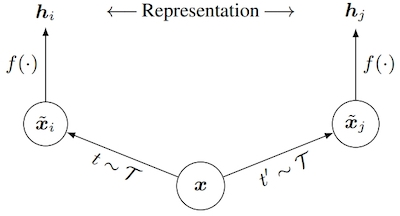

- 하나의 이미지에 각기 다른 Augmentation Compose를 가해줌 
- 인코더 + Projection Head를 통해 두개의 이미지를 모두 latnet vector로 만들어 줌 
- 동일 이미지 다른 Augmentation은 Positive Pair로 나머지 Batch image들은 모두 negative pair로 간주 
- Loss Function은 latent space에서 postive pair끼리는 가깝게, Negative Pair끼리는 멀게 학습이 진행 됨 

# NNCLR 

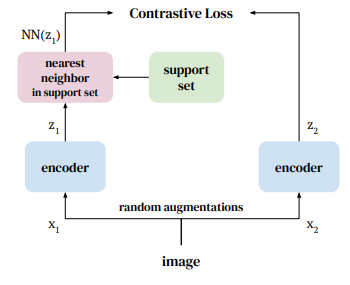

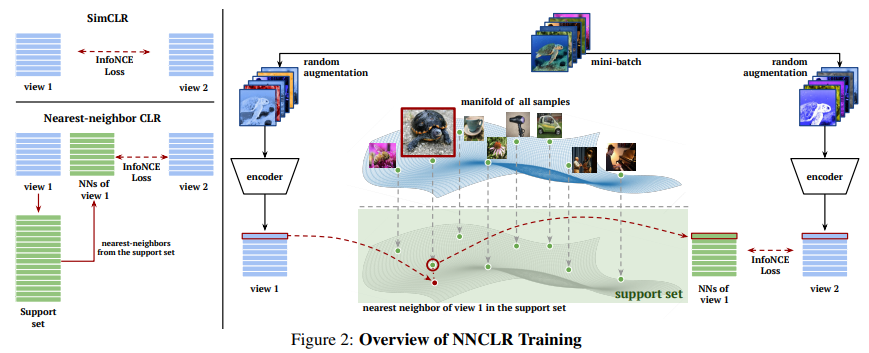

- SimCLR와는 유사하지만 Postive Pair를 위해 Memory Bank와 Nearest neighbour를 사용 
- SimCLR의 경우 Positive Pair가 동일한 이미지를 사용하기 때문에 동일 클래스, 다른 이미지에 대한 학습이 부족하다고 주장 
- 이를 single instance problem이라 정의 
- 따라서 NNCLR은 Encoder에서 출력된 latent vector와 유사한 것을 Memory Bank에서 가져오고 이를 이용해 Contrastie Learning 진행 
- 이러한 방법 덕분에 Augmentation에 대한 의존도는 적기 때문에 약한 Augmentation을 가해줌 

**Architecture** 
- Encoder : ResNet 50을 사용 
- Projection Head : Encoder 에서 출력된 vector를 contrastive loss를 위한 vector로 변환 해줌 
    - 여기서 출력된 latent vector는 nearest neighbour를 찾는데 사용 
    - MLP 3 layers : 2048, 2048, 256 
- Prediction Head : 
    - MLP 2 layers : 4096, 256 
    - Nearest Neighbor latent vector와 비교 용 
- Loss : InfoNCE : contrastive Loss 함수 
- Optimizer : LARS 
    - Batch size가 4096으로 매우 큼 
    - SimCLR에서도 큰 batch size가 필요하다 주장 
    - SGD,Adam은 큰 batch size에서 불안하기 때문에 큰 batch size에 적합한 LARS 옵티마이저 사용 


In [2]:
import os 
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import cv2 

import matplotlib.pyplot as plt 

from PIL import Image

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import torchvision 
from torchvision import transforms
from torchvision.datasets import STL10
import timm

#데이터 로더 
from utils import prepare_dataloader

#어그먼테이션 
from utils import augmenter

#model 
from utils import ResnetEncoder

# Load Dataset 
- STL 10 데이터셋 사용 
- Class : 10개 
- 학습용 라벨, 언라벨 데이터가 있음 

In [3]:
class Custom_Dset(Dataset):
    def __init__(self,dataset):
        super().__init__
        self.dataset = dataset 
        self.augmenter = self.__augmenter__() 

    def __len__(self):
        return len(self.dataset)

    def __augmenter__(self):
        augmentation = transforms.Compose([
            transforms.ToTensor()
        ])
        return augmentation

    def __getitem__(self,idx):
        img,label = self.dataset[idx]
        img = self.augmenter(img)

        return img, label 
        
def prepare_dataloader(batch_size):
    root = './Data'
    #train - label 
    label_train_stl10 = STL10(root=root,split='train')
    label_train_Dset = Custom_Dset(label_train_stl10)
    label_train_loader = DataLoader(label_train_Dset,batch_size=batch_size,shuffle=True)

    #train-unlabelled 
    unlabel_train_stl10 = STL10(root=root,split='unlabeled')
    unlabel_train_Dset = Custom_Dset(unlabel_train_stl10)
    unlabel_train_loader = DataLoader(unlabel_train_Dset,batch_size=batch_size,shuffle=True)

    #test 
    test_st10 = STL10(root=root,split='test')
    test_dset = Custom_Dset(test_st10)
    test_loader = DataLoader(test_dset,batch_size=batch_size,shuffle=False)

    print(len(label_train_stl10), len(unlabel_train_stl10),len(test_st10))
    
    return label_train_loader, unlabel_train_loader , test_loader

# Augmentation 
- SimCLR나 BYOL과 같은 다른 self-supervised 와 달리 NNCLR은 Augmentation에 대해 덜 의존적임 
- nearest-neighbors이 이미 같은 변수에 대해 풍부한 정보를 제공하기 때문 
- NNCLR은 complex augmentation에 덜 의존적이기 때문에 **Random Crop**, **Random Brightness** 만을 사용 

In [20]:
def augmenter(kwargs):
    brightness,_,scale = kwargs.values()
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96,scale=scale),
        transforms.ColorJitter(brightness=brightness)
    ])

# Encoder Architecture 

In [29]:
class ResnetEncoder(nn.Module):
    def __init__(self,vector_size=2048):
        super(ResnetEncoder,self).__init__()
        self.resnet50 = res50 = timm.create_model('resnet50',num_classes=vector_size,pretrained=True)

    def forward(self,x):
        x = self.resnet50(x)
        return x     

class ProjectionHead(nn.Module):
    def __init__(self):
        super(ProjectionHead,self).__init__()
        self.fc1 = self.linear_layer()
        self.fc2 = self.linear_layer()
        self.fc3 = nn.Sequential(nn.Linear(in_features=2048,out_features=256),
                                 nn.BatchNorm1d(256))

    def linear_layer(self,out_features=2048):
        Linear_layer = nn.Sequential(
            nn.Linear(in_features=2048,out_features=out_features),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )
        return Linear_layer 

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x 

class PredictionHead(nn.Module):
    def __init__(self):
        super(PredictionHead,self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2048,out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=4096,out_features=256)
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x 

class NNCLR(nn.Module):
    def __init__(self,device='cpu'):
        super(NNCLR,self).__init__()
        self.encoder = ResnetEncoder()
        self.projection_head = ProjectionHead().to(device)
        self.prediction_head = PredictionHead().to(device)

    def forward(self,x):
        x = self.encoder(x)
        z = self.projection_head(x)
        p = self.prediction_head(x)
        return z,p

# Memory Bank | Nearest Neighbor 

In [22]:
class MemoryBankModule(torch.nn.Module):
    def __init__(self, size: int = 2 ** 16):

        super(MemoryBankModule, self).__init__()

        if size < 0:
            msg = f'Illegal memory bank size {size}, must be non-negative.'
            raise ValueError(msg)

        self.size = size

        self.bank = None
        self.bank_ptr = None
    
    @torch.no_grad()
    def _init_memory_bank(self, dim: int):
        self.bank = torch.randn(dim, self.size)
        self.bank = torch.nn.functional.normalize(self.bank, dim=0)
        self.bank_ptr = torch.LongTensor([0])

    @torch.no_grad()
    def _dequeue_and_enqueue(self, batch: torch.Tensor):
        """Dequeue the oldest batch and add the latest one
        Args:
            batch:
                The latest batch of keys to add to the memory bank.
        """
        batch_size = batch.shape[0]
        ptr = int(self.bank_ptr)

        if ptr + batch_size >= self.size:
            self.bank[:, ptr:] = batch[:self.size - ptr].T.detach()
            self.bank_ptr[0] = 0
        else:
            self.bank[:, ptr:ptr + batch_size] = batch.T.detach()
            self.bank_ptr[0] = ptr + batch_size

    def forward(self,
                output: torch.Tensor,
                labels: torch.Tensor = None,
                update: bool = False):
        """Query memory bank for additional negatvie samples
        Args:
            output:
                The output of the model.
            labels:
                Should always be None, will be ignored.
        Returns:
            The output if the memory bank is of size 0, otherwise the output
            and the entries from the memory bank.
        """

        # no memory bank, return the output
        if self.size == 0:
            return output, None

        _, dim = output.shape

        # initialize the memory bank if it is not already done
        if self.bank is None:
            self._init_memory_bank(dim)

        # query and update memory bank
        bank = self.bank.clone().detach()

        # only update memory bank if we later do backward pass (gradient)
        if update:
            self._dequeue_and_enqueue(output)

        return output, bank




class NNMemoryBankModule(MemoryBankModule):
    """Nearest Neighbour Memory Bank implementation
    This class implements a nearest neighbour memory bank as described in the
    NNCLR paper[0]. During the forward pass we return the nearest neighbour
    from the memory bank.
    [0] NNCLR, 2021, https://arxiv.org/abs/2104.14548
    Attributes:
        size:
            Number of keys the memory bank can store. If set to 0,
            memory bank is not used.
    Examples:
        >>> model = NNCLR(backbone)
        >>> criterion = NTXentLoss(temperature=0.1)
        >>>
        >>> nn_replacer = NNmemoryBankModule(size=2 ** 16)
        >>>
        >>> # forward pass
        >>> (z0, p0), (z1, p1) = model(x0, x1)
        >>> z0 = nn_replacer(z0.detach(), update=False)
        >>> z1 = nn_replacer(z1.detach(), update=True)
        >>>
        >>> loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
    """
    def __init__(self, size: int = 2 ** 16):
        super(NNMemoryBankModule, self).__init__(size)

    def forward(self,
                output: torch.Tensor,
                update: bool = False):
        """Returns nearest neighbour of output tensor from memory bank
        Args:
            output: The torch tensor for which you want the nearest neighbour
            update: If `True` updated the memory bank by adding output to it
        """

        output, bank = super(NNMemoryBankModule, self).forward(output, update=update)
        bank = bank.to(output.device).t()

        output_normed = torch.nn.functional.normalize(output, dim=1)
        bank_normed = torch.nn.functional.normalize(bank, dim=1)
        #유사도 matrix 계산 : nearest neighbour 
        similarity_matrix = torch.einsum("nd,md->nm", output_normed,bank_normed)
        #유사도 matrix 에서 nearest neighbours indexing 
        index_nearest_neighbours = torch.argmax(similarity_matrix, dim=1)
        #index로 이용해 nearest neighbour 출력 
        nearest_neighbours = torch.index_select(bank, dim=0, index=index_nearest_neighbours)

        return nearest_neighbours

# Contrastive Loss 
- Contrastive Learning 을 위한 loss은 InfoNCE 사용 
- Positive Pair 끼리는 가깝게, Negative Pair끼리는 멀 도록 학습 

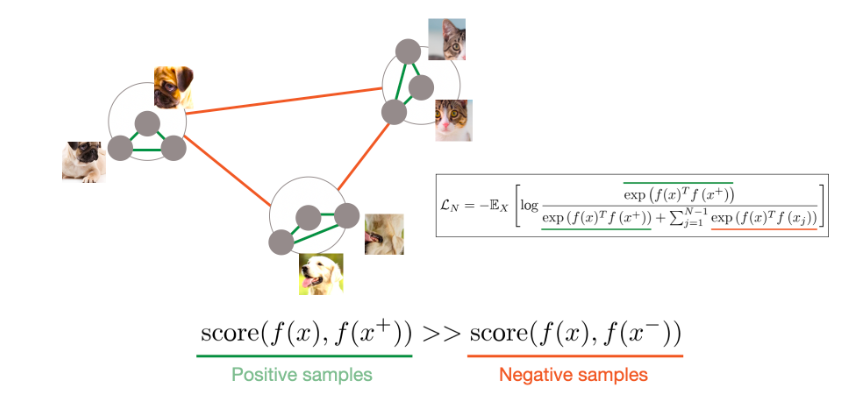

In [2]:
#InfoNCE는 별개의 패키지가 있어 그것을 사용 함 
#pip install info-nce-pytorch
from info_nce import InfoNCE
criterion = InfoNCE()

# Training 
- Temperature term 
    - softmax에 penalty를 주는 하이퍼 파라미터 
    - Hard Negative sample에 대한 penalty의 강도를 조절하는 역할 
    - Positve 와 negative 가 쉽게 분리가 되게 혹은 분리를 어렵게 할지 조절하는 요소 

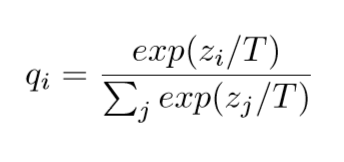

In [4]:
# 하이퍼 파라미터 

labelelled_train_images = 5000 
unlabelled_images = 100000

temperature = 0.1 
contrastive_augmenter = {
    "brightness" : 0.5, 
    "name" : "contrastive_augmenter",
    "scale" : (0.2,1.0)
}
classification_augmenter = {
    "brightness": 0.2,
    "name": "classification_augmenter",
    "scale": (0.5, 1.0),
}
input_shape = (96,96,3)
num_epochs = 500
batch_size= 4096 
learning_rate = 0.15 
device = 'cuda:0'

In [ ]:
#데이터 로더 로드 
label_train, unlabel_train, test = prepare_dataloader(batch_size=batch_size)

#Augmentation 로드 
contrastive_augmentation = augmenter(contrastive_augmenter)
classification_augmentation = augmenter(classification_augmenter)

#모델 로드 
model = NNCLR(device).to(device)
memory_bank = NNMemoryBankModule().to(device)

#compile 
#criterion = NTXentLoss()
#optimizer = torch.optim.Adam(lr=learning_rate,params=model.parameters())
criterion = InfoNCE()
optimizer = LARS(model.parameters(),lr=learning_rate,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=100,eta_min=0)

#Train 
for epoch in tqdm(range(num_epochs)):
    model.train() 
    epoch_loss = 0.
    n = 0 
    #이미지 데이터 로드 
    for (label_img,labels),(unlabel_img,_) in zip(label_train,unlabel_train):
        label_img,unlabel_img = label_img.to(device),unlabel_img.to(device)

        images = torch.concat((label_img,unlabel_img),axis=0).to(device)
        augmented_images_1 = contrastive_augmentation(images).to(device)
        augmented_images_2 = contrastive_augmentation(images).to(device)
    

        optimizer.zero_grad()

        z1,p1 = model(augmented_images_1)
        z2,p2 = model(augmented_images_2)

        z1 = memory_bank(z0,update=False)
        z2 = memory_bank(z1,update=True)
        loss = 0.5 * (criterion(z0,p1) + criterion(z1,p0))
        

        loss.backward()
        optimizer.step() 
        epoch_loss += loss 
        n+=1 
    print(f'Epoch : {epoch} | loss : {epoch_loss/n}')
    if epoch == 0:
        best = epoch_loss/n
        model_save(model,model_name='best.pt')
    if epoch_loss/n < best:
        model_save(model,model_name='best.pt')
        print(f'model save at {epoch}')
    


# Classification Fine tuning 
- Contrastive Learning을 진행한 후 Representation을 평가하기 위한 절차 
- Linear Evaluation Protocol에 맞춰 진행 
- 앞서 학습한 인코더에 Classification 용 linear layer를 하나 추가하여 분류 성능 확인 
- 학습한 인코더는 freeze하고 학습 진행 

In [4]:
device = 'cuda:0'
model_path = './save_models/best.pt'
model = torch.load(model_path).to(device)
root = './Data'

from utils import Custom_Dset
def train_loader():
    label_train_stl10 = STL10(root=root,split='train')
    label_train_Dset = Custom_Dset(label_train_stl10)
    label_train_loader = DataLoader(label_train_Dset,batch_size=32,shuffle=True)
    return label_train_loader 
    
class Classifier(nn.Module):
    def __init__(self,encoder,num_features):
        super(Classifier,self).__init__()
        self.encoder = self.__init_encoder__(encoder) 
        self.fc1 = nn.Linear(in_features=2048,out_features=num_features)

    def __init_encoder__(self,encoder):
        for name, params in encoder.named_parameters():
            if name not in ['fc.weight', 'fc.bias']:
                params.requires_grad = False
        return encoder 

    def forward(self,x):
        x = self.encoder(x)
        x = self.fc1(x)
        return x     

def score(y_,laels):
    y_pred = torch.argmax(y_,dim=1).detach().cpu().numpy()
    y_true = labels.detach().cpu().numpy()
    print(f1_score(y_true,y_pred,average='macro'))        

In [6]:
model =  Classifier(model.encoder,10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
train_load = train_loader()
num_epochs = 90

'''
for epoch in range(num_epochs):
    model.train()
    train_loss = 0. 
    for imgs,labels in train_load:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        y_ = model(imgs)

        loss = criterion(y_,labels)
        loss.backward()
        optimizer.step() 

        train_loss += loss 
    print(epoch)
    print(f'Train_loss : {train_loss/len(train_load)}')
    score(y_,labels)
''' 




"\nfor epoch in range(num_epochs):\n    model.train()\n    train_loss = 0. \n    for imgs,labels in train_load:\n        imgs = imgs.to(device)\n        labels = labels.to(device)\n        optimizer.zero_grad()\n\n        y_ = model(imgs)\n\n        loss = criterion(y_,labels)\n        loss.backward()\n        optimizer.step() \n\n        train_loss += loss \n    print(epoch)\n    print(f'Train_loss : {train_loss/len(train_load)}')\n    score(y_,labels)\n"

In [71]:
#latentv = np.zeros((len(train_load)-1)*2048).reshape(-1,2048)
latentv = [] 
latent_label = [] 
encoder = model.encoder
i = 0 
for img,label in train_load:
    img,label = img.to(device),label.to(device)

    vector = encoder(img)
    vector, label = vector.detach().cpu().numpy(), label.detach().cpu().numpy() 
    s = i*32 
    f = (i+1)*32
    latentv.extend(vector)
    latent_label.extend(label)
    i+=1 
latentv = np.array(latentv)
latent_label = np.array(latent_label)

In [78]:
from sklearn.manifold import TSNE
tsnt = TSNE()
after_tsne = tsnt.fit_transform(latentv)

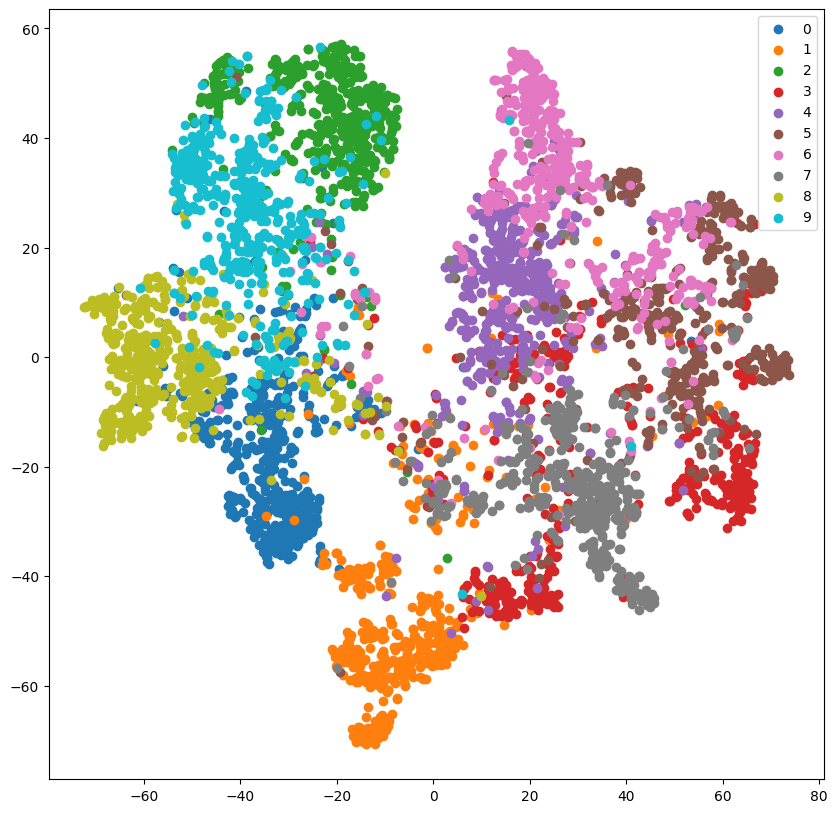

In [94]:
uniques = np.unique(latent_label)

plt.figure(figsize=(10,10))
for label in uniques:
    label_idx = np.where(latent_label==label)
    label_vector = after_tsne[label_idx[0]]
    plt.scatter(x=label_vector[:,0],
                y=label_vector[:,1],
                label=label)
    plt.legend()
plt.show()